In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!nvidia-smi

Sun May 14 07:19:46 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.68                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti    WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P0               16W /  N/A|      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# !rm -r indonlu

In [4]:
!git clone https://github.com/ezaaputra/indonlu.git

fatal: destination path 'indonlu' already exists and is not an empty directory.


# 1. Import Library

In [5]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

# NLP
import nltk
nltk.download('punkt')
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

#Model IndoBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\didin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 2. Exploratory Data Analysis

In [7]:
df_path = 'vision_mentah_second.csv'
stopword_path = 'stopword.txt'
kamus_alay_path = 'kamus_gokil.csv'

In [8]:
# Import data
df = pd.read_csv(df_path)

In [9]:
df.sample(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
1599,cfdb9341-68d5-4e22-97b8-843d214a520f,Isra Abdullah,https://play-lh.googleusercontent.com/a/AGNmyx...,"Saya kecewa, katanya semua saluran ternyata TV...",3,2,6.13.0,2022-04-09 05:47:21,Terima kasih atas review-nya. Jika ingin menda...,2022-04-09 11:22:23
7467,658eab09-5e3f-42f5-be34-4b3341e9fb9c,Ikhsan Maulana,https://play-lh.googleusercontent.com/a-/ACB-R...,Saya sangat tidak nyaman makai aplikasi ini Ke...,2,0,NaN,2022-07-25 18:41:57,Mohon Maaf atas ketidaknyamanannya. Silahkan c...,2022-07-25 18:52:48
7718,39143307-e51a-4af0-93ac-2e0c9feba081,D3 1a Tlm 2019,https://play-lh.googleusercontent.com/a/AGNmyx...,Keren aplikasi nya bisa nonton film dengan nya...,5,0,NaN,2020-10-11 15:49:00,"Terima kasih atas review-nya, selamat menikmat...",2020-10-11 16:25:39
2526,da72b388-cb1e-4ae6-ba7b-fd19e98118f1,Wulan Rahma,https://play-lh.googleusercontent.com/a/AGNmyx...,"Untung ada aplikasi ini, aku jadi gak rebutan ...",5,0,NaN,2020-10-11 20:29:37,"Terima kasih atas review-nya, selamat menikmat...",2020-10-12 03:20:27
4459,a8bdb76f-ed50-4a35-ab6c-3173efe0534d,Kamil Hapis,https://play-lh.googleusercontent.com/a/AGNmyx...,Kenapa ko tv premium siaran ulangnya gak ada.....,3,0,6.0.1,2021-02-11 05:27:43,\nMohon maaf atas ketidaknyamanannya. Untuk ca...,2021-02-11 09:01:46


In [10]:
print(f'shape: {df.shape}')

shape: (8000, 10)


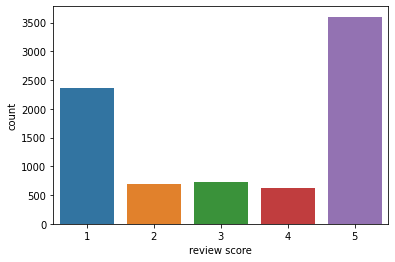

In [11]:
sns.countplot(x=df["score"])
plt.xlabel('review score');

In [12]:
def to_sentiment(rating):
    
    rating = int(rating)
    
    # Convert to class
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

# Apply to the dataset 
df['category'] = df["score"].apply(to_sentiment)


In [13]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,category
0,e62be63f-800b-4aa1-acb1-235a13cd3ba9,Muhammad Sofyan Zain,https://play-lh.googleusercontent.com/a-/ACB-R...,Saya masih ngetes dulu nih berlangganan 1 bula...,1,4,6.24.0,2023-04-28 19:36:30,Hi Villenial...Mohon Maaf atas ketidaknyamanan...,2023-04-28 21:13:27,0
1,8857ee5e-6a31-404e-a3bc-547b0c2337ba,Dinna Agsari,https://play-lh.googleusercontent.com/a-/ACB-R...,Tolong tingkatkan lagi. Lagi enak2 nonton samp...,1,29,6.24.0,2023-04-23 09:10:39,Mohon Maaf atas ketidaknyamanannya kak Dinna. ...,2023-04-23 10:15:16,0
2,c7de4e7e-dd9a-4319-9186-4ee6abb3bec6,Bary Hastomo Kristyadi,https://play-lh.googleusercontent.com/a-/ACB-R...,"Wah.. Status langganan masih aktif, tp dipake ...",1,1,6.24.0,2023-04-29 20:23:21,Mohon Maaf atas ketidaknyamanannya kak Bary .....,2023-04-30 00:50:53,0
3,4d2a5e1d-a99c-4b18-a2d0-75252bf6d544,Syamila,https://play-lh.googleusercontent.com/a-/ACB-R...,"Aplikasinya jelek, udah langganan premium eh b...",1,1,6.24.0,2023-04-28 14:06:58,Hi Villenial....Mohon Maaf atas ketidaknyamana...,2023-04-28 14:17:52,0
4,2e1c3d16-21e5-4d33-a626-08ba1d003c75,Ash,https://play-lh.googleusercontent.com/a-/ACB-R...,"Kalo mau pilih episode susah, dipencet2 tetep ...",2,52,6.22.0,2023-02-07 20:19:35,Hi Villenial....Mohon maaf atas ketidaknyamana...,2023-02-07 20:35:53,0


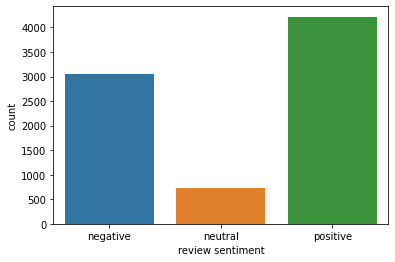

In [14]:
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(x = df["category"])
ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names)

plt.xlabel('review sentiment')
plt.show()

In [15]:
def to_sentiment(rating):
    
    rating = int(rating)
    
    # Convert to class
    if rating <= 2:
        return "negative"
    elif rating == 3:
        return "neutral"
    else:
        return "positive"

# Apply to the dataset 
df['category'] = df["score"].apply(to_sentiment)

In [16]:
df["category"].value_counts()

positive    4219
negative    3060
neutral      721
Name: category, dtype: int64

## Proporsi Variabel Target

In [17]:
df['category'].value_counts()

positive    4219
negative    3060
neutral      721
Name: category, dtype: int64

In [18]:
# Function to make a donut chart
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%', 
           startangle = angle, pctdistance=0.8, explode = explode, 
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')  
    plt.tight_layout()

In [19]:
# Plot arguments
sizes = df.category.value_counts()
labels = ['Review Baik', 'Review Netral', 'Review Negatif']
colors = ['lightgreen', 'lightskyblue', 'lightcoral']
explode = (0,0,0)

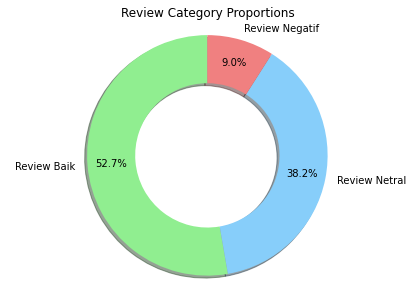

In [20]:
# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Review Category Proportions')

plt.show()

# 3. PreProcessing

## Preprocessing Tahap 1

In [21]:
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yang berulang
def repeatcharClean(text): 
  for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long 
      text = text.replace(char,character[i])
      charac_long -= 1
  return text

In [22]:
def clean_review(text):
  # ubah text menjadi huruf kecil
  text = text.lower()
  # ubah enter menjadi spasi
  text = re.sub(r'\n', ' ', text)
  # hapus emoji
  text = emoji.demojize(text)
  text = re.sub(':[A-Za-z_-]+:', ' ', text) # delete emoji
  # hapus emoticon
  text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)
  # hapus link
  text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text)
  # hapus usename
  text = re.sub(r"@[^\s]+[\s]?", ' ', text)
  # hapus hashtag
  text = re.sub(r'#(\S+)', r'\1', text)
  # hapus angka dan beberapa simbol
  text = re.sub('[^a-zA-Z,.?!]+',' ',text)
  # hapus karakter berulang
  text = repeatcharClean(text)
  # clear spasi
  text = re.sub('[ ]+',' ',text)
  return text

In [23]:
def preprocess_v1(df):
  df_pp = df.copy()
  df_pp.content = df_pp.content.map(clean_review)

  # delete empty row
  df_pp.content.replace('', np.nan, inplace=True)
  df_pp.content.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['content'], inplace=True)
  return df_pp

In [24]:
df_v1 = preprocess_v1(df)

In [25]:
# export to tsv
# df_v1.to_csv('df_v1.tsv', sep='\t', header=None, index=False)

## Preprocessing Tahap 2

In [26]:
# additional_stopword:list kata tdk penting
additional_stop = [] #['ya', 'deh', 'dia']
# default stopword
default_stop = pd.read_csv(stopword_path, names=['stopwords'])
default_stop = default_stop.stopwords.to_list()
# combine all stopword
list_stopwords = []
list_stopwords = default_stop + additional_stop
# remove specific stopword
# list_stopwords.remove("sangat")
# list_stopwords.remove("sekali")

In [27]:
kamus_alay = pd.read_csv(kamus_alay_path) 

normalize_word_dict = {}
for index, row in kamus_alay.iterrows():
    if row[0] not in normalize_word_dict:
        normalize_word_dict[row[0]] = row[1]

In [28]:
def normalize_review(text):
  # tokenize
  list_text = word_tokenize(text)
  # ubah bahasa alay
  list_text = [normalize_word_dict[term] if term in normalize_word_dict else term for term in list_text]
  # stemming
  # factory = StemmerFactory()
  # stemmer = factory.create_stemmer()
  # list_text = [stemmer.stem(word) for word in list_text]
  # hapus kata yang termasuk stopword
  # list_text = [word for word in list_text if word not in list_stopwords]
  # gabung kembali kalimat
  text = " ".join(list_text)
  return text

In [29]:
def preprocess_v2(df):
  df_pp = df.copy()
  df_pp.content = df_pp.content.map(normalize_review)

  # delete empty row
  df_pp.content.replace('', np.nan, inplace=True)
  df_pp.content.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['content'], inplace=True)
  return df_pp

In [30]:
# take a while
df_v2  = preprocess_v2(df_v1)

In [31]:
# export to tsv
# df_v2.to_csv('df_v2.tsv', sep='\t', header=None, index=False)

In [32]:
def make_corpus(column):
    
    corpus_list = []

    for text in column:
        cleaned_list = text.split(' ')
        corpus_list.extend(cleaned_list)     
        
    # transform list of words into 1 body of text
    corpus = ' '.join(corpus_list)
    corpus = re.sub('[ ]+',' ',corpus) # replace double whitespace with one
        
    return corpus

In [33]:
# Takes a while
corpus = make_corpus(df_v2.content)

In [34]:
# counting unique words
corpus_set = set(corpus.split(' '))

print(f'Count of unique words in corpus: {len(corpus_set)}')

Count of unique words in corpus: 10261


In [35]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples 
    
    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})
    
    return df

In [36]:
corpus_freq = word_freq(corpus, top=20)

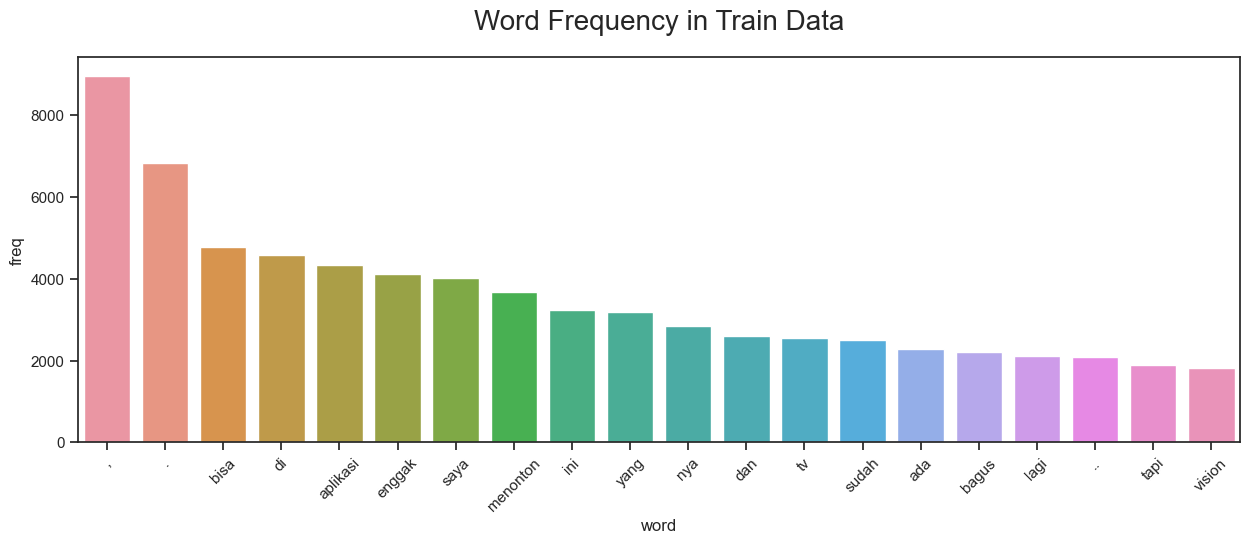

In [37]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))

sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)

# sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax2)
# ax2.set_title('Word Frequency in Train Data')
# ax2.tick_params(axis='x', rotation=45)

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

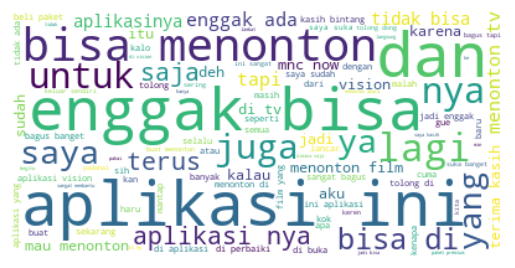

In [38]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 4. Splitting

In [39]:
# train val split
train_set, val_set = train_test_split(df_v2, test_size=0.3, stratify=df_v2.category, random_state=1)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.category, random_state=1)

In [40]:
print(f'Train shape: {train_set.shape}')
print(f'Val shape: {val_set.shape}')
print(f'Test shape: {test_set.shape}')

Train shape: (5599, 11)
Val shape: (1608, 11)
Test shape: (792, 11)


In [41]:
train_set.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,category
2714,aced06de-188f-41df-a255-6ab835ace7ab,elly latifa,https://play-lh.googleusercontent.com/a/AGNmyx...,"mantul sekale appnya , banyak chanel pilihan y...",5,0,NaN,2020-10-09 16:08:41,"Terima kasih reviewnya, kami akan terus tingka...",2020-10-09 16:09:10,positive
5061,ed24ef38-261e-44df-abc7-864ee9d57f17,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,ya sudah di download hanya tidak ada gambarnya...,5,0,3.3.9,2018-09-17 20:59:34,Mohon Maaf atas ketidaknyamanannya.Silakan men...,2018-09-17 21:51:38,positive
7226,3b86948e-aea8-4a60-99a3-aa48f9caa6f6,Wawan Sndi,https://play-lh.googleusercontent.com/a-/ACB-R...,aplikasi babi buat menonton tv saja susah bang...,1,0,NaN,2023-04-10 22:24:29,Mohon Maaf atas ketidaknyamanannya. Silahkan c...,2023-04-10 22:36:40,negative
760,3c0909ec-02df-46ff-9ef3-e9492fa0ea3a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,streaming terputus otomatis setelah menit . en...,2,0,3.3.21,2019-04-22 09:31:34,Mohon Maaf atas ketidaknyamanannya.Silakan cob...,2019-04-22 09:32:47,negative
5039,5a6c9027-64b2-4cec-bf24-93bbda5acdb3,Lucas lucy,https://play-lh.googleusercontent.com/a/AGNmyx...,aplikasinya bagus tapi pas gue menonton kok ka...,3,0,4.4.5,2020-08-01 19:05:48,Mohon Maaf atas ketidaknyamanannya. Silakan co...,2020-08-01 21:39:22,neutral


In [42]:
train_set_main = train_set[["content", "category"]]
val_set_main = val_set[["content", "category"]]
test_set_main = test_set[["content", "category"]]
train_set_main.head()

,content,category
2714,"mantul sekale appnya , banyak chanel pilihan y...",positive
5061,ya sudah di download hanya tidak ada gambarnya...,positive
7226,aplikasi babi buat menonton tv saja susah bang...,negative
760,streaming terputus otomatis setelah menit . en...,negative
5039,aplikasinya bagus tapi pas gue menonton kok ka...,neutral


In [43]:
# export to tsv
train_set_main.to_csv('train_set.tsv', sep='\t', header=None, index=False)
val_set_main.to_csv('val_set.tsv', sep='\t', header=None, index=False)
test_set_main.to_csv('test_set.tsv', sep='\t', header=None, index=False)

# 5. Modeling

## a. Finetuning IndoBERT

In [44]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [45]:
# Set random seed
set_seed(27)

## b. Load Model

In [46]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
# Struktur model
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [48]:
count_param(model)

124443651

## c. Prepare Dataset

In [49]:
train_dataset_path = 'train_set.tsv'
valid_dataset_path = 'val_set.tsv'
test_dataset_path = 'test_set.tsv'

In [50]:
# fungsi dataset loader dari utils IndoNLU
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)  
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

c:\Users\didin\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [51]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i) #word to index
print(i2w) #index to word

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


## d. Uji coba pre-trained model

In [52]:
text = 'Saya masih ngetes dulu nih berlangganan 1 bulan yg sport'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Saya masih ngetes dulu nih berlangganan 1 bulan yg sport | Label : negative (47.005%)


In [65]:
text = 'Gk jelas sinyal nya full tapi kalu buka aplk ini sinyal langsung hilang dan error gk bisa di buka...kecewa banget'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Gk jelas sinyal nya full tapi kalu buka aplk ini sinyal langsung hilang dan error gk bisa di buka...kecewa banget | Label : negative (48.546%)


In [54]:
text = 'Sudah beli paket premium tapi gak bisa dipake nonton, harus login terus.. habis login tetep aja gak bisa dipake, suruh beli paket lagi'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Sudah beli paket premium tapi gak bisa dipake nonton, harus login terus.. habis login tetep aja gak bisa dipake, suruh beli paket lagi | Label : negative (49.653%)


In [55]:
print(torch.cuda.is_available())

False


## e. Fine Tuning & Prediksi Evaluation

In [56]:
# Tentukan optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

AssertionError: Torch not compiled with CUDA enabled

### Training

In [ ]:
# Train
n_epochs = 5
history = defaultdict(list)
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Hitung skor train metrics
        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    
    # save train acc for learning curve
    history['train_acc'].append(metrics['ACC'])

    # Evaluate di validation set
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
        # Hitung total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Hitung skor evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    # save validation acc for learning curve
    history['val_acc'].append(metrics['ACC'])

  0%|          | 0/175 [00:00<?, ?it/s]c:\Users\didin\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/175 [01:12<?, ?it/s]


AssertionError: Torch not compiled with CUDA enabled

### Learning Curve

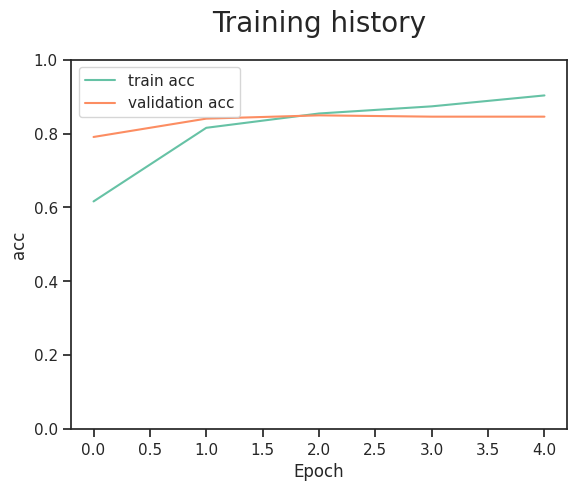

In [ ]:
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# Simpan Hasil Prediksi Validation Set
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['content', 'category'])
val_df['pred'] = list_hyp
val_df.head()
val_df.to_csv('val result.csv', index=False)

## f. Prediksi Test Set

In [ ]:
# Prediksi test set
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
pred, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 9/9 [00:03<00:00,  2.66it/s]


In [ ]:
# Simpan prediksi test set
test_df = pd.read_csv(test_dataset_path, sep='\t', names=['content', 'category'])
test_df['pred'] = pred
test_df.head()
test_df.to_csv('test result.csv', index=False)

## e. Test fine-tuned model on sample sentences

In [ ]:
text = 'tidak bisa transfer antar bank'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: tidak bisa transfer antar bank | Label : negative (94.544%)


In [ ]:
text = 'bisa transfer antar bank'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bisa transfer antar bank | Label : positive (67.669%)


In [ ]:
text = 'bisa transfer antar bank?'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bisa transfer antar bank? | Label : neutral (90.922%)


# 6. Evaluasi

In [ ]:
val_real = val_df.category
val_pred = val_df.pred

test_real = test_df.category
test_pred = test_df.pred

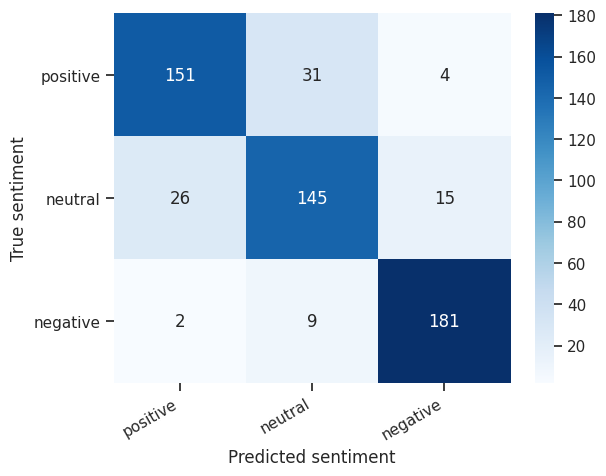

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  
cm = confusion_matrix(val_real, val_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(val_real, val_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.84      0.81      0.83       186
     neutral       0.78      0.78      0.78       186
    negative       0.91      0.94      0.92       192

    accuracy                           0.85       564
   macro avg       0.84      0.84      0.84       564
weighted avg       0.84      0.85      0.85       564



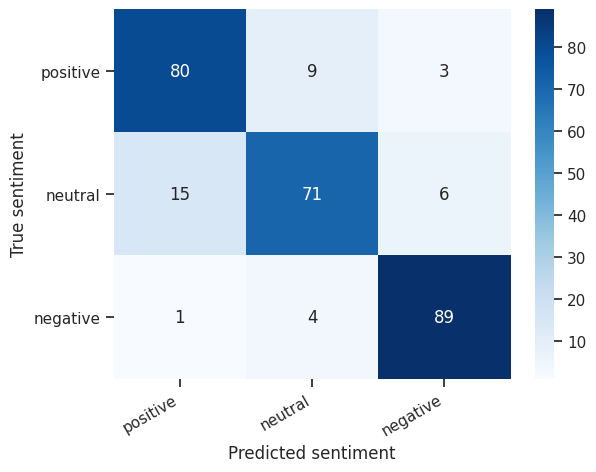

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  
cm = confusion_matrix(test_real, test_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(test_real, test_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.83      0.87      0.85        92
     neutral       0.85      0.77      0.81        92
    negative       0.91      0.95      0.93        94

    accuracy                           0.86       278
   macro avg       0.86      0.86      0.86       278
weighted avg       0.86      0.86      0.86       278

